In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import zero_one_loss
from sklearn.metrics import make_scorer, f1_score

**Load The Data**

In [ ]:
current_dir = os.getcwd()
relative_path = os.path.join('..','..', 'data', 'x_train.csv')
x_train=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train.csv')
y_train=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_val.csv')
x_val=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_val.csv')
y_val=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_test.csv')
x_test=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_test.csv')
y_test=pd.read_csv(os.path.join(current_dir, relative_path))

**AdaBoost**

Perform grid search to get the best parameters

In [3]:
warnings.filterwarnings("ignore")
# Define the parameter grid for grid search
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2),
                       DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4),
                       DecisionTreeClassifier(max_depth=5)],
    'n_estimators': [10, 20, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]
}

# Initialize AdaBoostClassifier
ada_clf = AdaBoostClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best model
best_ada_clf = grid_search.best_estimator_
# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.5, 'n_estimators': 50}


In [4]:
base_estimator = best_params['base_estimator']
n_estimators = best_params['n_estimators']
learning_rate = best_params['learning_rate']
print(f'Best base_estimator: {base_estimator}')
print(f'Best n_estimators: {n_estimators}')
print(f'Best learning_rate: {learning_rate}')

Best base_estimator: DecisionTreeClassifier(max_depth=1)
Best n_estimators: 50
Best learning_rate: 0.5


Get The Training Accuracy

In [8]:
# Predict on the training set
y_train_pred = best_ada_clf.predict(x_train)

# Calculate training accuracy (in-sample error)
training_accuracy = accuracy_score(y_train, y_train_pred)

print("Training Accuracy:", training_accuracy)

weighted_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Training Weighted F1-score:", weighted_f1)

Training Accuracy: 0.8819148936170212
Training Weighted F1-score: 0.8615521686587793


Get The Validation Accuracy

In [9]:
# Predict on the validation set
y_val_pred = best_ada_clf.predict(x_val)

val_accuracy = best_ada_clf.score(x_val, y_val)
print("Validation Accuracy:", val_accuracy)

weighted_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Validation Weighted F1-score:", weighted_f1)

Validation Accuracy: 0.8771186440677966
Validation Weighted F1-score: 0.8522443717469504


Get The cross validation Accuracy

In [10]:
# Perform k-fold cross-validation (with 5 folds)
scores = cross_val_score(ada_clf, x_train, y_train, cv=5)

In [11]:
# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.83510638 0.83510638 0.86702128 0.83510638 0.88829787]
Mean cross-validation score: 0.852127659574468


Classification report

In [12]:
# Predict on validation set
y_val_pred = best_ada_clf.predict(x_val)

# Calculate precision, recall, and F1-score
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print("Classification Report for Validation Set:")
print(report)

Classification Report for Validation Set:
              precision    recall  f1-score   support

     Class 0       0.87      1.00      0.93       191
     Class 1       1.00      0.36      0.52        45

    accuracy                           0.88       236
   macro avg       0.93      0.68      0.73       236
weighted avg       0.89      0.88      0.85       236



Confusion Matrix

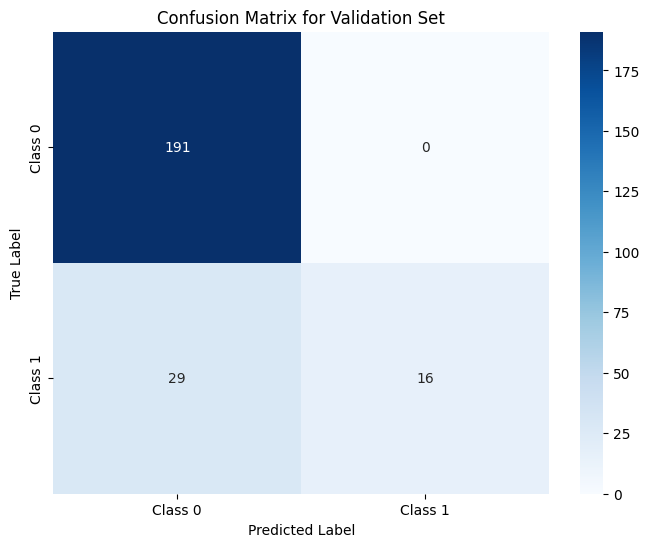

In [13]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Plot Learning Curve with scores

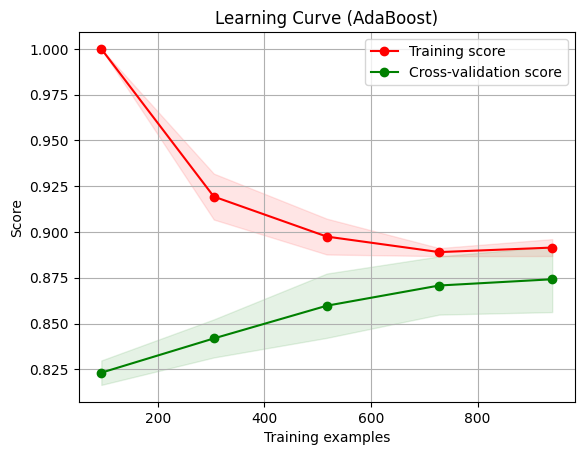

In [14]:
warnings.filterwarnings("ignore")
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

# Plot learning curve
plot_learning_curve(best_ada_clf, "Learning Curve (AdaBoost)", X, y, cv=5)
plt.show()

Plot Learning Curve with errors

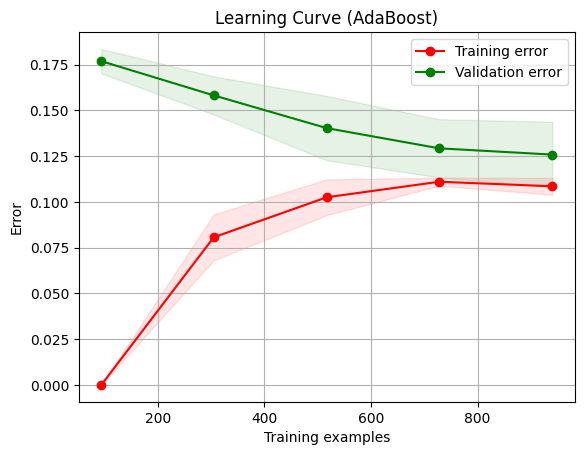

In [15]:
warnings.filterwarnings("ignore")
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the training and validation learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_errors_mean = -np.mean(train_scores, axis=1)
    train_errors_std = np.std(train_scores, axis=1)
    test_errors_mean = -np.mean(test_scores, axis=1)
    test_errors_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Validation error")

    plt.legend(loc="best")
    return plt

X = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

# Plot learning curve
plot_learning_curve(best_ada_clf, "Learning Curve (AdaBoost)", X, y, cv=5)
plt.show()

In [ ]:
'''
The decreasing training score suggests that as more training examples are provided, the model is exposed to a wider variety of instances and is learning to generalize better.
This is a positive sign as it indicates that the model is not memorizing the training data but rather learning meaningful patterns.

The increasing validation score indicates that the model's performance on unseen data is improving as more training examples are provided.
This suggests that the model is generalizing well to new instances and is not overfitting to the training data.

The small gap between the training and validation scores suggests that the model is not suffering from significant overfitting.
The fact that both scores are increasing with a small gap indicates that the model is learning to generalize well to unseen data without excessively fitting to the training data.

The fact that both the training and validation scores are eventually increasing slowly that the model's performance is stabilizing as more data is provided.
This is a desirable outcome, indicating that additional data may not significantly improve the model's performance further.

'''

Training & Validation errors vs number of learning estimators

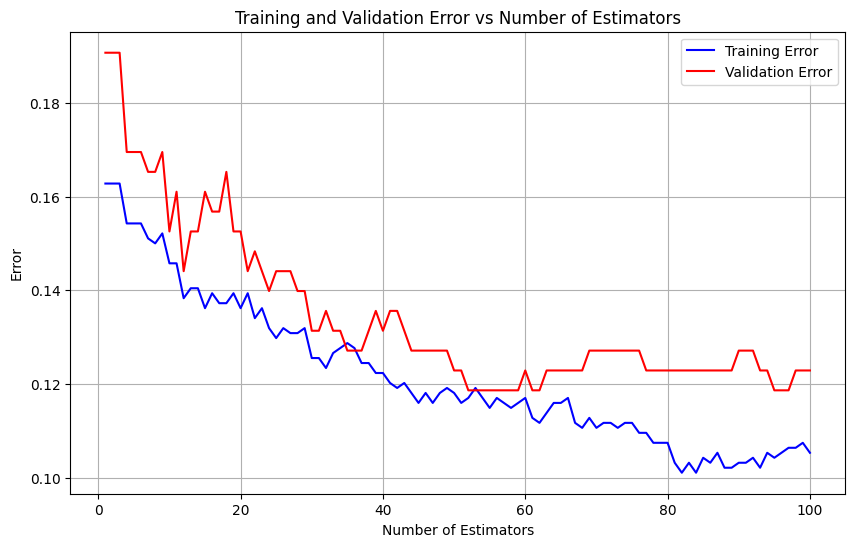

In [ ]:
# Initialize lists to store training and validation errors
train_errors = []
val_errors = []

# Define the range of n_estimators values
n_estimators_range = range(1, 101)

# Loop over n_estimators values
for n_estimators in n_estimators_range:
    # Initialize AdaBoost classifier with DecisionTree base estimator
    ada_clf = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=n_estimators,
        random_state=42,
        learning_rate=0.5
    )

    # Fit the model on the training data
    ada_clf.fit(x_train, y_train)

    # Calculate training error
    train_error = zero_one_loss(y_train, ada_clf.predict(x_train))
    train_errors.append(train_error)

    # Calculate validation error
    val_error = zero_one_loss(y_val, ada_clf.predict(x_val))
    val_errors.append(val_error)

# Plot training and validation errors
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_errors, label='Training Error', color='blue')
plt.plot(n_estimators_range, val_errors, label='Validation Error', color='red')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Training and Validation Error vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
'''
• Boosting is often robust to overfitting.
• Test set error decreases even after training error is almost zero
'''

'\n• Boosting is often robust to overfitting.\n• Test set error decreases even after training error is almost zero\n'

Train over all the data (training + validation)

In [16]:
new_x_data = np.concatenate((x_train, x_val), axis=0)
new_y_data = np.concatenate((y_train, y_val), axis=0)

In [17]:
# Fit the model on the new data
best_ada_clf.fit(new_x_data, new_y_data)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5)

Get The Testing Accuracy

In [18]:
warnings.filterwarnings("ignore")
# Predict on the test set
y_test_pred = best_ada_clf.predict(x_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on Test Set:", accuracy_test)

weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')

print("Test Weighted F1-score:", weighted_f1)

Accuracy on Test Set: 0.8707482993197279
Validation Weighted F1-score: 0.8415702101736217


In [19]:
# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_test_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print("Classification Report for Test Set:")
print(report)

Classification Report for Test Set:
              precision    recall  f1-score   support

     Class 0       0.89      0.98      0.93       255
     Class 1       0.54      0.18      0.27        39

    accuracy                           0.87       294
   macro avg       0.71      0.58      0.60       294
weighted avg       0.84      0.87      0.84       294



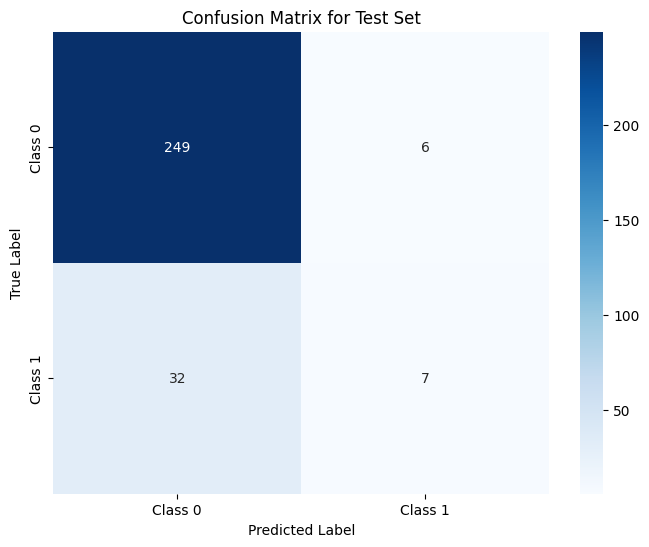

In [20]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()